In [1]:
# %matplotlib notebook
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler
from NeuralNetwork import NeuralNetwork
from PIL import Image
import os

In [2]:
from sklearn.datasets import load_iris, load_digits


def load_data_flowers():
    data = load_iris()
    input_data = data['data']
    output_data = data['target']
    outputs_name = data['target_names']
    feature_names = list(data['feature_names'])
    feature_1 = [feat[feature_names.index('sepal length (cm)')] for feat in input_data]
    feature_2 = [feat[feature_names.index('sepal width (cm)')] for feat in input_data]
    feature_3 = [feat[feature_names.index('petal length (cm)')] for feat in input_data]
    feature_4 = [feat[feature_names.index('petal width (cm)')] for feat in input_data]
    input_data = [[feat[feature_names.index('sepal length (cm)')],
                   feat[feature_names.index('sepal width (cm)')],
                   feat[feature_names.index('petal length (cm)')],
                   feat[feature_names.index('petal width (cm)')]] for feat in input_data]
    return input_data, output_data, outputs_name, feature_1, feature_2, feature_3, feature_4, feature_names


def load_data_digit():
    data = load_digits()
    input_data = data.images
    output_data = data['target']
    outputs_name = data['target_names']
    return input_data, output_data, outputs_name


Functions for ploting data

In [3]:
import plotly.express as px


def plot_data_four_features(input_data, output_data, feature_names, title=None):
    x = [i[0] for i in input_data]
    y = [i[1] for i in input_data]
    z = [i[2] for i in input_data]
    v = [i[3] for i in input_data]
    figure = px.scatter_3d(x=x, y=y, z=z, symbol=v, color=output_data, title=title,
                           labels=dict(x=feature_names[0], y=feature_names[1], z=feature_names[2],
                                       symbol=feature_names[3], color="Type"))
    figure.update_layout(legend=dict(orientation="v", yanchor='top', xanchor="right"))
    figure.show()


def plot_histogram_feature(feature, variable_name):
    plt.hist(feature, 10)
    plt.title('Histogram of ' + variable_name)
    plt.show()


def plot_histogram_data(output_data, outputs_name, title):
    plt.hist(output_data, 10)
    plt.title('Histogram of ' + title)
    plt.xticks(np.arange(len(outputs_name)), outputs_name)
    plt.show()

Split the data into train and test

In [4]:
def train_and_test(input_data, output_data):
    indexes = [i for i in range(len(input_data))]
    train_sample = np.random.choice(indexes, int(0.8 * len(input_data)), replace=False)
    test_sample = [i for i in indexes if i not in train_sample]
    train_inputs = [input_data[i] for i in train_sample]
    train_outputs = [output_data[i] for i in train_sample]
    test_inputs = [input_data[i] for i in test_sample]
    test_outputs = [output_data[i] for i in test_sample]
    return train_inputs, train_outputs, test_inputs, test_outputs

Normalise the data

In [5]:
def normalisation(train_data, test_data):
    scaler = StandardScaler()
    if not isinstance(train_data[0], list) and not isinstance(train_data[0], np.ndarray):
        train_data = [[d] for d in train_data]
        test_data = [[d] for d in test_data]
        scaler.fit(train_data)
        normalised_train_data = scaler.transform(train_data)
        normalised_test_data = scaler.transform(test_data)
        normalised_train_data = [el[0] for el in normalised_train_data]
        normalised_test_data = [el[0] for el in normalised_test_data]
    else:
        scaler.fit(train_data)
        normalised_train_data = scaler.transform(train_data)
        normalised_test_data = scaler.transform(test_data)
    return scaler, normalised_train_data, normalised_test_data

def flatten_data(train_data, test_data):
    def flatten(mat):
        x = []
        for line in mat:
            for el in line:
                x.append(el)
        return x
    train_data = [flatten(data) for data in train_data]
    test_data = [flatten(data) for data in test_data]
    return train_data, test_data

Learn model

In [6]:
def classifier_by_tool(train_inputs, train_outputs, test_inputs, test_outputs):
    classifier = neural_network.MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=10000, solver='sgd',
                                              verbose=0, random_state=1, learning_rate_init=.1)
    classifier.fit(train_inputs, train_outputs)
    computed_outputs = classifier.predict(test_inputs)
    print('Accuracy by tool:', classifier.score(test_inputs, test_outputs))
    return computed_outputs


def classifier_by_me(train_inputs, train_outputs, test_inputs, hidden_layer_size=10, max_iter=7000, learning_rate=.001):
    classifier = NeuralNetwork(hidden_layer_size=hidden_layer_size, max_iter=max_iter, learning_rate=learning_rate)
    classifier.fit(np.array(train_inputs), np.array(train_outputs))
    plt.plot(classifier.loss, [index for index in range(len(classifier.loss))])
    plt.show()
    computed_outputs = classifier.predict(test_inputs)
    return computed_outputs

Plot confusion matrix

In [7]:
from sklearn.metrics import confusion_matrix as cm
import itertools

def evaluate(test_outputs, computed_labels, output_names):
    confusion_matrix_calculated = cm(test_outputs, computed_labels)
    acc = sum([confusion_matrix_calculated[i][i] for i in range(len(output_names))]) / len(test_outputs)
    prec = {}
    rec = {}
    for i in range(len(output_names)):
        prec[output_names[i]] = confusion_matrix_calculated[i][i] / sum([confusion_matrix_calculated[j][i] for j in range(len(output_names))])
        rec[output_names[i]] = confusion_matrix_calculated[i][i] / sum([confusion_matrix_calculated[i][j] for j in range(len(output_names))])
    print('Accuracy: ', acc)
    print('Precision: ', prec)
    print('Recall: ', rec) 
    return confusion_matrix_calculated

def plot_confusion_matrix(cm, class_names, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                 horizontalalignment='center',
                 color='white' if cm[row, column] > thresh else 'black')
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Main function

IRIS


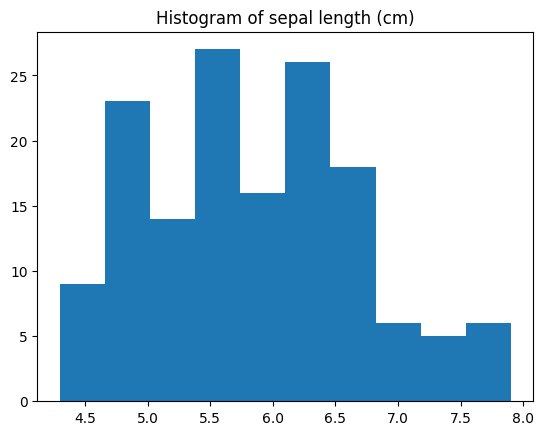

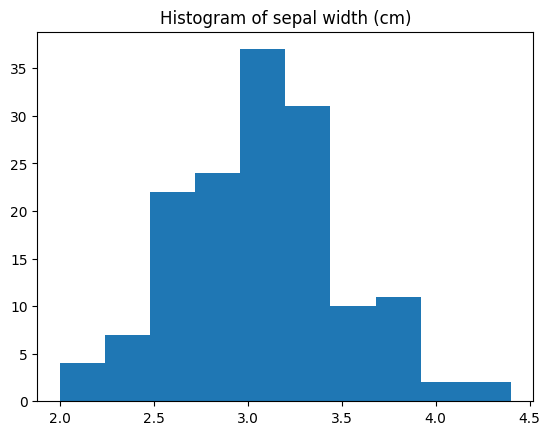

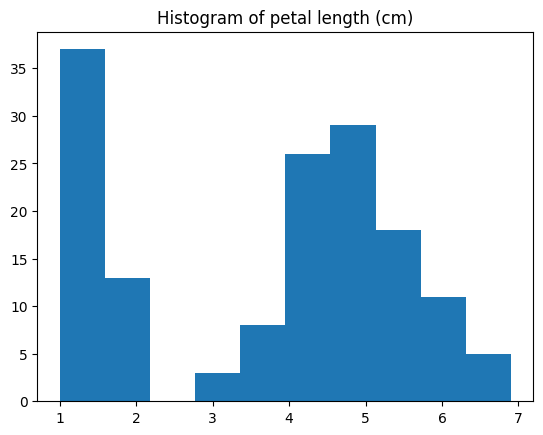

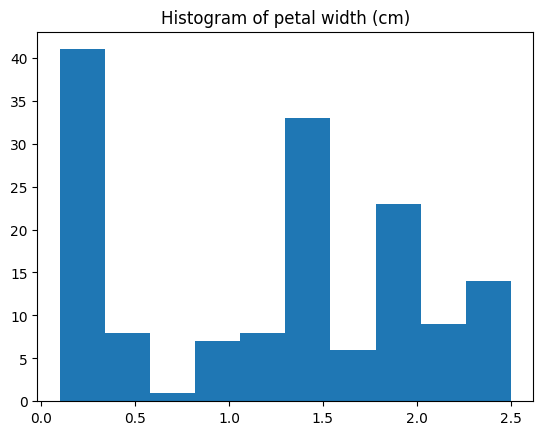

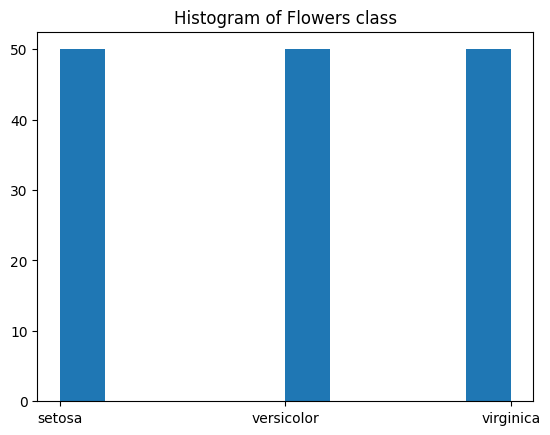

Accuracy by tool: 1.0
Computed: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Real:     [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]



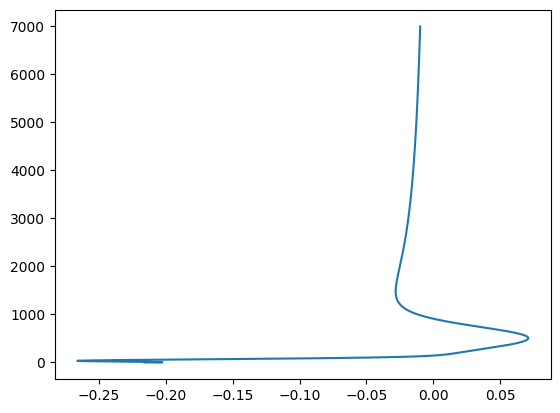

Computed by me: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Real:           [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Accuracy:  1.0
Precision:  {'setosa': 1.0, 'versicolor': 1.0, 'virginica': 1.0}
Recall:  {'setosa': 1.0, 'versicolor': 1.0, 'virginica': 1.0}


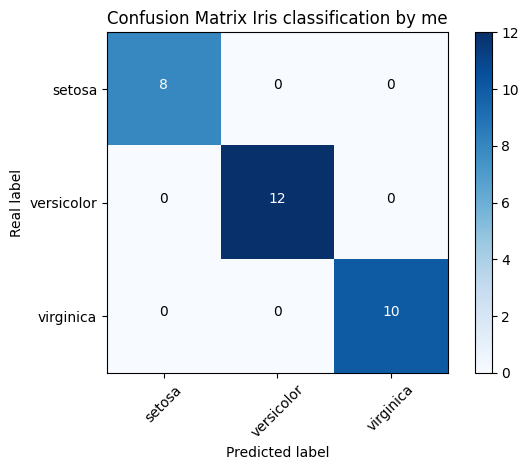



DIGITS


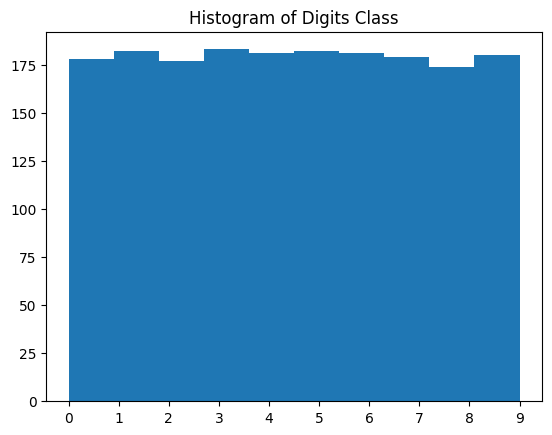

Accuracy by tool: 0.9083333333333333
Computed: [2, 4, 1, 9, 2, 5, 0, 3, 6, 0, 2, 6, 4, 6, 4, 7, 6, 3, 1, 6, 1, 9, 8, 3, 1, 4, 5, 2, 8, 9, 2, 5, 6, 7, 5, 6, 9, 0, 0, 6, 7, 5, 0, 1, 8, 4, 2, 2, 8, 8, 0, 8, 8, 1, 4, 5, 7, 1, 3, 3, 7, 5, 5, 1, 0, 2, 7, 5, 0, 0, 0, 3, 2, 7, 6, 3, 1, 1, 7, 4, 7, 2, 8, 7, 4, 8, 8, 1, 2, 5, 9, 1, 5, 5, 8, 1, 7, 2, 8, 3, 1, 7, 6, 4, 8, 3, 1, 1, 4, 8, 4, 7, 4, 9, 6, 9, 2, 6, 7, 9, 3, 4, 2, 6, 9, 3, 6, 5, 5, 2, 2, 7, 3, 1, 1, 5, 4, 9, 8, 3, 5, 7, 0, 1, 7, 6, 9, 9, 5, 7, 3, 2, 0, 1, 3, 1, 0, 5, 4, 3, 7, 4, 9, 5, 6, 5, 2, 2, 5, 5, 2, 8, 4, 8, 4, 3, 3, 5, 1, 8, 8, 9, 0, 8, 2, 3, 2, 4, 6, 1, 7, 4, 0, 6, 1, 4, 2, 2, 2, 8, 8, 1, 9, 0, 6, 4, 5, 5, 2, 7, 3, 3, 0, 6, 0, 9, 1, 4, 5, 6, 6, 1, 7, 9, 4, 9, 1, 5, 9, 6, 3, 6, 2, 7, 3, 8, 6, 5, 2, 3, 9, 2, 0, 7, 6, 5, 2, 2, 2, 7, 4, 1, 9, 6, 4, 6, 5, 7, 4, 8, 9, 0, 3, 0, 5, 7, 0, 7, 9, 5, 5, 5, 8, 9, 3, 3, 6, 4, 0, 9, 6, 1, 0, 2, 1, 3, 9, 8, 3, 4, 6, 2, 2, 1, 8, 4, 0, 1, 8, 0, 5, 6, 0, 4, 9, 9, 1, 7, 0, 2, 5, 5, 2, 9, 7, 6, 4, 6

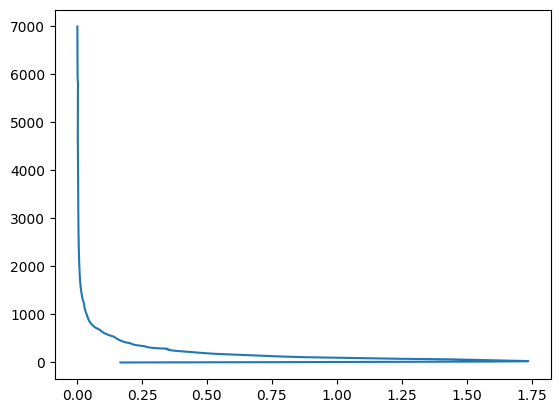

Computed by me: [2, 4, 1, 9, 2, 5, 0, 3, 2, 0, 2, 6, 4, 6, 4, 7, 6, 3, 1, 6, 1, 9, 8, 3, 1, 4, 5, 2, 8, 1, 2, 3, 6, 7, 5, 6, 9, 0, 0, 6, 7, 5, 0, 1, 8, 4, 2, 8, 8, 3, 0, 8, 8, 1, 4, 5, 7, 1, 3, 3, 7, 5, 9, 1, 0, 2, 9, 5, 0, 0, 0, 3, 2, 7, 6, 3, 1, 1, 7, 4, 5, 2, 8, 7, 4, 8, 8, 1, 2, 5, 9, 1, 5, 5, 8, 1, 7, 2, 8, 3, 1, 7, 6, 4, 8, 3, 1, 1, 4, 8, 4, 8, 4, 9, 6, 9, 2, 6, 7, 8, 3, 4, 2, 6, 3, 3, 6, 5, 5, 2, 8, 7, 3, 1, 1, 5, 4, 9, 8, 3, 5, 7, 0, 1, 7, 6, 9, 9, 5, 7, 3, 2, 0, 1, 3, 1, 0, 5, 4, 3, 7, 4, 4, 5, 6, 5, 2, 2, 5, 5, 2, 8, 6, 8, 5, 9, 3, 5, 1, 5, 8, 9, 4, 5, 8, 3, 2, 4, 6, 1, 7, 5, 0, 6, 1, 4, 2, 2, 2, 8, 8, 1, 9, 0, 6, 4, 5, 5, 1, 7, 5, 3, 0, 6, 1, 9, 1, 4, 5, 6, 6, 1, 7, 7, 4, 9, 1, 5, 9, 6, 3, 6, 2, 7, 3, 3, 6, 5, 2, 3, 9, 2, 0, 7, 6, 5, 2, 2, 2, 7, 4, 1, 9, 6, 4, 6, 5, 7, 4, 8, 9, 0, 3, 0, 5, 7, 0, 7, 9, 5, 5, 5, 8, 7, 3, 3, 4, 4, 0, 9, 6, 8, 0, 2, 1, 3, 9, 8, 3, 4, 6, 2, 2, 8, 8, 4, 0, 1, 8, 0, 5, 6, 0, 4, 9, 9, 1, 7, 0, 2, 5, 5, 2, 9, 7, 6, 4, 6, 9, 1, 4, 4, 8, 9, 0, 1, 0, 9,

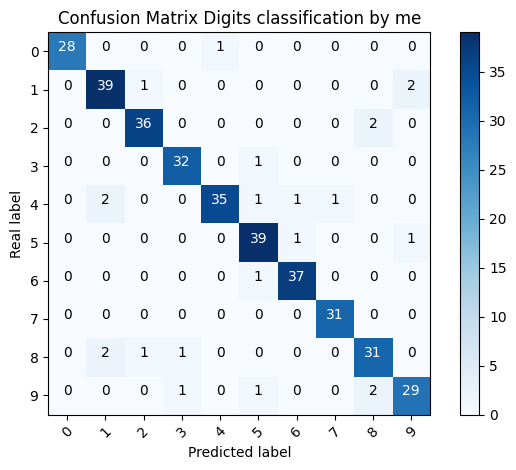

In [8]:
print("IRIS")
inputs, outputs, outputNames, feature1, feature2, feature3, feature4, featureNames = load_data_flowers()
# plot_data_four_features(inputs, outputs, featureNames, "Initial data for flowers")
plot_histogram_feature(feature1, featureNames[0])
plot_histogram_feature(feature2, featureNames[1])
plot_histogram_feature(feature3, featureNames[2])
plot_histogram_feature(feature4, featureNames[3])
plot_histogram_data(outputs, outputNames, 'Flowers class')
trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
_, trainInputs, testInputs = normalisation(trainInputs, testInputs)
# plot_data_four_features(trainInputs, trainOutputs, featureNames, "Normalised flowers' data")
computedOutputs = classifier_by_tool(trainInputs, trainOutputs, testInputs, testOutputs)
print('Computed:', list(computedOutputs))
print('Real:    ', testOutputs)
print()
computedOutputsByMe = classifier_by_me(trainInputs, trainOutputs, testInputs)
print('Computed by me:', computedOutputsByMe)
print('Real:          ', testOutputs)
confusion_matrix_by_me = evaluate(np.array(testOutputs), np.array(computedOutputsByMe), outputNames)
plot_confusion_matrix(confusion_matrix_by_me, outputNames, "Iris classification by me")


print('\n\nDIGITS')
inputs, outputs, outputNames = load_data_digit()
plot_histogram_data(outputs, outputNames, 'Digits Class')
trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
trainInputs, testInputs = flatten_data(trainInputs, testInputs)
_, trainInputs, testInputs = normalisation(trainInputs, testInputs)
computedOutputs = classifier_by_tool(trainInputs, trainOutputs, testInputs, testOutputs)
print('Computed:', list(computedOutputs))
print('Real:    ', testOutputs)
print()
computedOutputsByMe = classifier_by_me(trainInputs, trainOutputs, testInputs)
print('Computed by me:', list(computedOutputsByMe))
print('Real:          ', testOutputs)
confusion_matrix_by_me = evaluate(np.array(testOutputs), np.array(computedOutputsByMe), outputNames)
plot_confusion_matrix(confusion_matrix_by_me, outputNames, "Digits classification by me")

Transform original images into sepia images

In [9]:
def sepia_image(image_path):
    image = Image.open(image_path)

    img = np.array(image)

    filt = cv2.transform(img, np.matrix([[0.393, 0.769, 0.189],
                                        [ 0.349, 0.686, 0.168],
                                        [ 0.272, 0.534, 0.131]]))

    filt[np.where(filt>255)] = 255

    return Image.fromarray(filt)

def save_sepia_images():
    for img in os.listdir('data/original'):
        sepia_img = sepia_image('data/original/' + img)
        sepia_img.save('data/sepia/' + img)
    
save_sepia_images()

Classify sepia images and original images - ANN classification

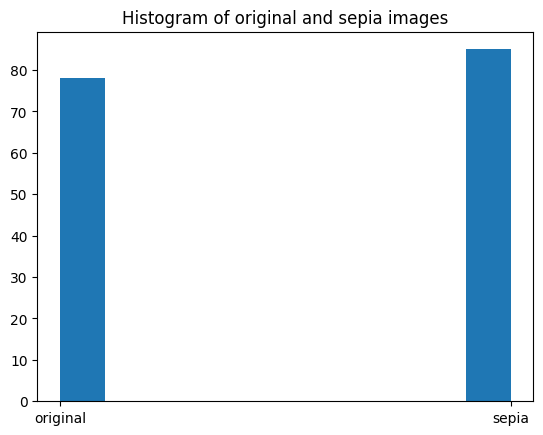

Computed: [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Real:     [0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1
 0 0 0 0]
Accuracy:  0.8048780487804879
Precision:  {'original': 0.9444444444444444, 'sepia': 0.6956521739130435}
Recall:  {'original': 0.7083333333333334, 'sepia': 0.9411764705882353}


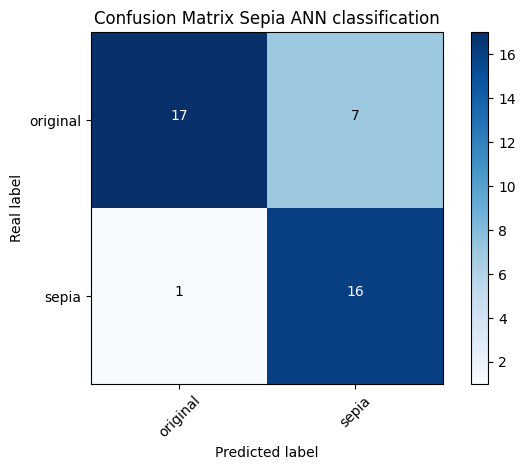

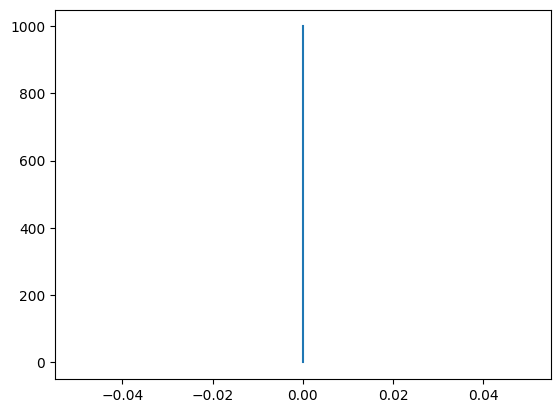

Computed by me: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Real:           [0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1
 0 0 0 0]
Accuracy:  0.4146341463414634
Precision:  {'original': nan, 'sepia': 0.4146341463414634}
Recall:  {'original': 0.0, 'sepia': 1.0}


/tmp/ipykernel_11264/2856958293.py:10: RuntimeWarning: invalid value encountered in scalar divide
  prec[output_names[i]] = confusion_matrix_calculated[i][i] / sum([confusion_matrix_calculated[j][i] for j in range(len(output_names))])


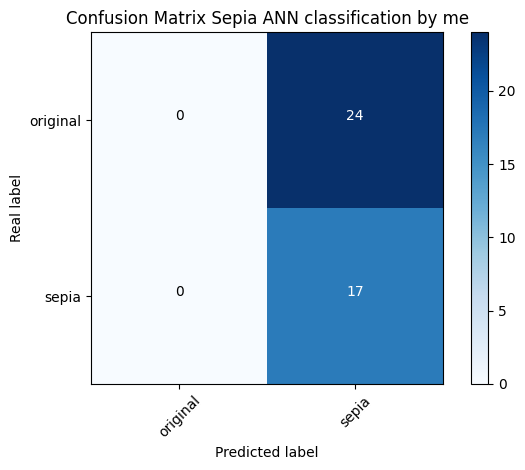

In [20]:
def process_image(path):
    img = Image.open(path)
    img = np.asarray(img)
    processed = []
    for i in img:
        processed += list(i)
    return np.ravel(processed) / 255.0


def process_folder():
    inputs_data = []
    outputs_data = []
    for img in os.listdir('data/original'):
        inputs_data.append(process_image('data/original/' + img))
        outputs_data.append(0)
        inputs_data.append(process_image('data/sepia/' + img))
        outputs_data.append(1)
    return inputs_data, outputs_data


def train_by_tool(train_inputs, train_outputs, test_inputs):
    classifier = neural_network.MLPClassifier(hidden_layer_sizes=(10, 25, 10), max_iter=7000)
    classifier.fit(train_inputs, train_outputs)
    computed_outputs = classifier.predict(test_inputs)
    return computed_outputs


if __name__ == '__main__':
    outputNames = ['original', 'sepia']
    imgSize = 64
    inputData, outputData = process_folder()
    trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputData, outputData)
    trainInputs = np.array(trainInputs)
    trainOutputs = np.array(trainOutputs)
    testInputs = np.array(testInputs)
    testOutputs = np.array(testOutputs)
    plot_histogram_data(trainOutputs, outputNames, 'original and sepia images')
    computedOutputs = train_by_tool(trainInputs, trainOutputs, testInputs)
    print('Computed:', list(computedOutputs))
    print('Real:    ', testOutputs)
    confusion_matrix = evaluate(np.array(testOutputs), np.array(computedOutputs), outputNames)
    plot_confusion_matrix(confusion_matrix, outputNames, "Sepia ANN classification")
    print()
    computedOutputsByMe = classifier_by_me(trainInputs, trainOutputs, testInputs, hidden_layer_size=12, max_iter=1000, learning_rate=.001)
    print('Computed by me:', list(computedOutputsByMe))
    print('Real:          ', testOutputs)
    confusion_matrix_by_me = evaluate(np.array(testOutputs), np.array(computedOutputsByMe), outputNames)
    plot_confusion_matrix(confusion_matrix_by_me, outputNames, "Sepia ANN classification by me")

Classify sepia images and original images - CNN classification

In [19]:
# from tensorflow.python.keras.optimizer_v2.adam 
import tensorflow as tf
import cv2
import os

def train_and_test_cnn(data):
    indexes = [i for i in range(len(data))]
    train_sample = np.random.choice(indexes, int(0.8 * len(data)), replace=False)
    test_sample = [i for i in indexes if i not in train_sample]
    train = [data[i] for i in train_sample]
    test = [data[i] for i in test_sample]
    return train, test

def inputs_outputs_normalisation(train, test, img_size):
    train_input = []
    train_output = []
    test_input = []
    test_output = []
    for feature, label in train:
        train_input.append(feature)
        train_output.append(label)
    for feature, label in test:
        test_input.append(feature)
        test_output.append(label)
    train_input = np.array(train_input) / 255.0
    test_input = np.array(test_input) / 255.0
    train_input.reshape(-1, img_size, img_size, 1)
    train_output = np.array(train_output)
    # train_output = tf.keras.utils.to_categorical(train_output, 2)
    test_input.reshape(-1, img_size, img_size, 1)
    test_output = np.array(test_output)
    # test_output = tf.keras.utils.to_categorical(test_output, 2)
    return train_input, train_output, test_input, test_output

def process_folder(directory, label, img_size):
    data = []
    path = os.path.join(directory, label)
    for img_file in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img_file))
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, label])
        except Exception as e:
            print(f"Error processing image {img_file}: {e}")
    return data


def read_images(img_size):
    data = []
    for label in ['original', 'sepia']:
        data += process_folder('data', label, img_size)
    return np.array(data)


def train_model(img_size, trainInputs, trainOutputs, testInputs, testOutputs):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))  
    opt = tf.keras.optimizers.Adam(learning_rate=.001)
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(trainInputs, trainOutputs, epochs=35, validation_data=(testInputs, testOutputs))
    computedOutputs = model.predict(testInputs)
    return computedOutputs


if __name__ == '__main__':
    outputNames = ['original', 'sepia']
    img_size = 64
    data = read_images(img_size)
    train, test = train_and_test_cnn(data)
    trainInput, trainOutput, testInput, testOutput = inputs_outputs_normalisation(train, test, img_size)
    computedOutputs = train_model(img_size, trainInputs, trainOutputs, testInputs, testOutputs)
    computedOutputs = [list(elem).index(max(list(elem))) for elem in computedOutputs]
    print(computedOutputs)
    confusion_matrix = evaluate(testOutputs, computedOutputs, outputNames)
    plot_confusion_matrix(confusion_matrix, outputNames, "Sepia CNN classification")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (204, 2) + inhomogeneous part.